In [1]:
# Inspiration for this test
# https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [2]:
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

In [3]:
root_dir = os.getcwd()

# Where to save the model for classifications
model_path = root_dir + '/classification-models/v2'

directory = "Plots/run_2_folders/split/"

size = 240

In [3]:

# Resizes images to sensible resolution and converts them to JPGs
def resize():
    for root, dirs, files in os.walk(directory):
        path = root.split(os.sep)
        for file in files:
            if file.endswith(".png"):
                filepath = root_dir + "/" + "/".join(path) + "/" + file
                im = Image.open(filepath)
                # Convert to RGB since JPGs don't support transparency
                im = im.convert('RGB')
                f, e = os.path.splitext(filepath)
                imResize = im.resize((size,size), Image.ANTIALIAS)
                imResize.save(f + '-resized.jpg', 'JPEG', quality=90)
                # Delete original PNG
                os.remove(filepath)
    
    print("✅ All images resized")

resize()


✅ All images resized


In [4]:
# V1 of the model
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=directory + "Training", target_size=(size,size))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=directory + "Validation", target_size=(size,size))

labels = traindata.class_indices
print(labels)

no_classes = len(labels)

Found 1711 images belonging to 6 classes.
Found 428 images belonging to 6 classes.
{'ball_and_cloud': 0, 'core_intensifying': 1, 'hamburger_or_ufo': 2, 'maxwellian': 3, 'maxwellian_cut_or_squished': 4, 'widening_starting': 5}


In [ ]:
# TODO: load saved model if needed
# model = keras.models.load_model(model_path)

In [5]:
model = Sequential()

model.add(Conv2D(input_shape=(size,size,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=no_classes, activation="softmax"))

print("✅ Model ready!")

2022-03-15 20:11:20.806052: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Model ready!


In [6]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'], run_eagerly=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 512)     295424    
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 512)     2359808   
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 512)     2359808   
                                                        

In [ ]:
import gc

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

# https://github.com/tensorflow/tensorflow/issues/31312#issuecomment-821809246
class clearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()


checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#model.fit(traindata, epochs=100, validation_data=testdata, callbacks=[checkpoint, early, clearMemory]) 

hist = model.fit_generator(
    generator=traindata, 
    validation_data=testdata,
    epochs=100,
    callbacks=[checkpoint,early]
)

print("✅ Fitting completed")

/var/folders/cc/8bsksmrj41xdrbtgxrj55d8c0000gn/T/ipykernel_8996/615897015.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100


In [137]:
model.save(model_path)

INFO:tensorflow:Assets written to: /Users/jonne/university/plasma-dsp2022/classification-models/v1/assets


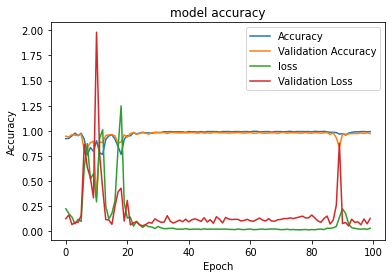

In [138]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

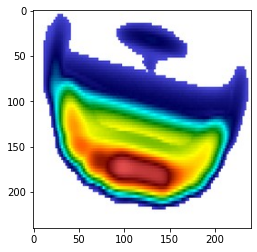

cut_maxwellian:     0.0005
distorted:     0.9978
flattened_maxwellian:     0.0001
lowres_maxwellian:     0.0000
max_and_line:     0.0000
maxwellian:     0.0013
ufo:     0.0003


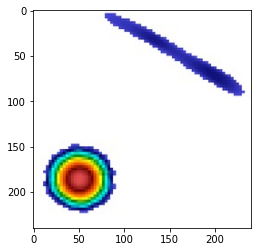

cut_maxwellian:     0.0000
distorted:     0.0000
flattened_maxwellian:     0.0000
lowres_maxwellian:     0.0000
max_and_line:     1.0000
maxwellian:     0.0000
ufo:     0.0000


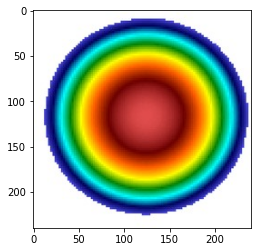

cut_maxwellian:     0.0001
distorted:     0.0000
flattened_maxwellian:     0.0000
lowres_maxwellian:     0.0000
max_and_line:     0.0000
maxwellian:     0.9999
ufo:     0.0000


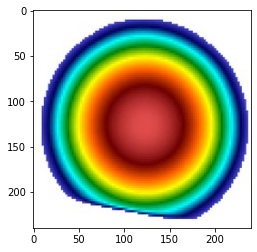

cut_maxwellian:     1.0000
distorted:     0.0000
flattened_maxwellian:     0.0000
lowres_maxwellian:     0.0000
max_and_line:     0.0000
maxwellian:     0.0000
ufo:     0.0000


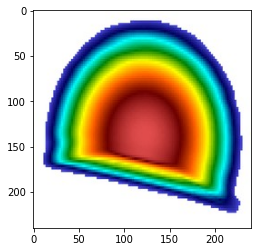

cut_maxwellian:     0.9996
distorted:     0.0000
flattened_maxwellian:     0.0004
lowres_maxwellian:     0.0000
max_and_line:     0.0000
maxwellian:     0.0000
ufo:     0.0000


In [142]:
from keras.preprocessing import image

images = [
    "Validation/distorted/plot_vdf_proton_cellid_951_t90_xz_proj-resized.jpg",
    "Validation/max_and_line/plot_vdf_proton_cellid_1101_t140_xz_proj-resized.jpg",
    "Validation/maxwellian/plot_vdf_proton_cellid_426_t30_xz_proj-resized.jpg",
    "Validation/cut_maxwellian/plot_vdf_proton_cellid_526_t140_xz_proj-resized.jpg",
    "Validation/flattened_maxwellian/plot_vdf_proton_cellid_801_t90_xz_proj-resized.jpg"
]

for image_file in images:
    image_path = root_dir + "/" + directory + image_file

    img = image.load_img(image_path,target_size=(size,size))
    img = np.asarray(img)
    plt.imshow(img)
    plt.show()
    img = np.expand_dims(img, axis=0)

    output = model.predict(img)
    probabilities = output[0]

    for idx, key in enumerate(labels.keys()):
        print(key + ": " + "{:10.4f}".format(probabilities[idx]))
        
